<a href="https://colab.research.google.com/github/simeonnalovski/NLP-Sentiment-Analysis-and-Text-Generation-in-Finance-/blob/main/Pseudo_Fine_Tuned_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install newsapi-python

In [ ]:
!!pip install datasets

['Requirement already satisfied: datasets in /usr/local/lib/python3.11/dist-packages (2.14.4)',
 'Requirement already satisfied: numpy>=1.17 in /usr/local/lib/python3.11/dist-packages (from datasets) (2.0.2)',
 'Requirement already satisfied: pyarrow>=8.0.0 in /usr/local/lib/python3.11/dist-packages (from datasets) (18.1.0)',
 'Requirement already satisfied: dill<0.3.8,>=0.3.0 in /usr/local/lib/python3.11/dist-packages (from datasets) (0.3.7)',
 'Requirement already satisfied: pandas in /usr/local/lib/python3.11/dist-packages (from datasets) (2.2.2)',
 'Requirement already satisfied: requests>=2.19.0 in /usr/local/lib/python3.11/dist-packages (from datasets) (2.32.3)',
 'Requirement already satisfied: tqdm>=4.62.1 in /usr/local/lib/python3.11/dist-packages (from datasets) (4.67.1)',
 'Requirement already satisfied: xxhash in /usr/local/lib/python3.11/dist-packages (from datasets) (3.5.0)',
 'Requirement already satisfied: multiprocess in /usr/local/lib/python3.11/dist-packages (from da

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/3 - Loss: 1.8436
Epoch 2/3 - Loss: 1.2427
Epoch 3/3 - Loss: 0.9210

 Stock: AMZN
Mean sentiment score (Fine-tuned FinBERT): 1.5700
Total sentiment score: 157
Sentiment category: positive
Data saved to: /content/drive/MyDrive/data/stock_sentiment.csv

 Evaluating Original FinBERT against RoBERTa-labeled news
 Accuracy:   0.1500
 Precision:  0.1177
 Recall:     0.1500
 F1 Score:   0.1304


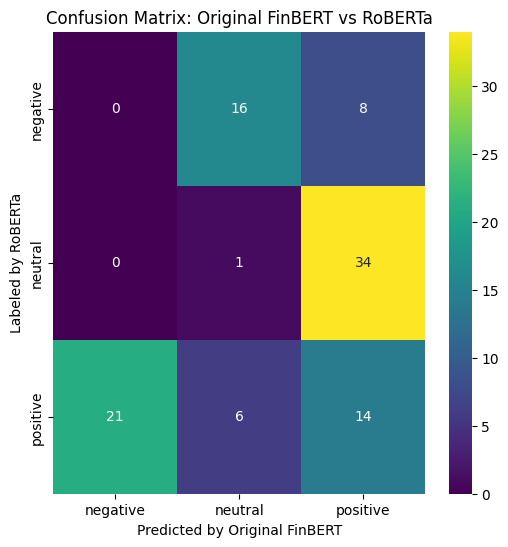


 Evaluating Fine-tuned FinBERT against RoBERTa-labeled news
 Accuracy:   0.6800
 Precision:  0.7652
 Recall:     0.6800
 F1 Score:   0.6399


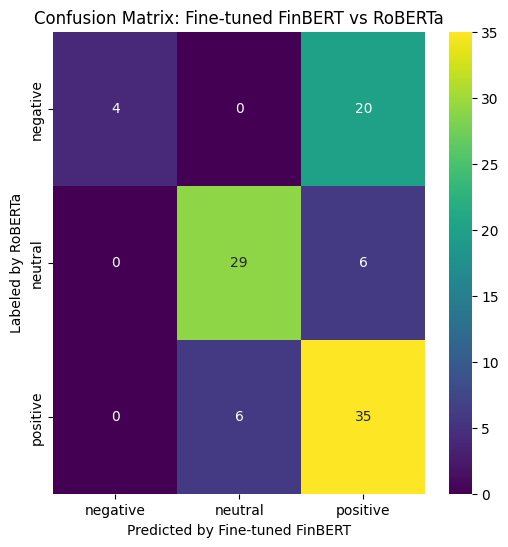

(0.68, 0.7652459016393443, 0.68, 0.6399439775910365)

In [ ]:
import os
import torch
import pandas as pd
from datetime import datetime, timedelta, timezone
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from torch.optim import AdamW  # Correct import here
import seaborn as sns
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
OUTPUT_PATH = '/content/drive/MyDrive/data/stock_sentiment.csv'
NEWS_API_KEY = "YOUR_NEWS_API_KEY"
STOCK_SYMBOL = "AMZN"

# Load Models
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
original_finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)
finetuned_finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)
roberta_pipe = pipeline("text-classification", model="soleimanian/financial-roberta-large-sentiment")

# News API
newsapi = NewsApiClient(api_key=NEWS_API_KEY)

# Dataset Class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label)
        }

# Fetch news
def fetch_recent_news(stock_symbol):
    end_date = datetime.now(timezone.utc)
    start_date = max(end_date - timedelta(days=28))
    articles = newsapi.get_everything(
        q=stock_symbol,
        from_param=start_date.strftime('%Y-%m-%d'),
        to=end_date.strftime('%Y-%m-%d'),
        language='en',
        sort_by='relevancy',
        page_size=100,
        page=1
    )
    return [article["title"] for article in articles.get("articles", []) if article["title"]]

# Classify functions
def classify_with_finbert(model, tokenizer, texts, batch_size=16):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i: i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).tolist()
        results.extend(predictions)
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    return [label_map[p] for p in results]

def classify_with_roberta(texts):
    preds = roberta_pipe(texts, truncation=True, padding=True)
    return [p["label"].lower() for p in preds]

# fino-podesuvanje na FinBERT
def finetune_finbert(
    model, tokenizer, texts, labels,
    epochs=3, batch_size=16, lr=2e-5, weight_decay=0.01, max_seq_length=128
):
    dataset = NewsDataset(texts, labels, tokenizer, max_length=max_seq_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

# Sentiment Category
def get_sentiment_category(mean_score):
    normalized_score = mean_score / 2
    if normalized_score < 0.3:
        return "negative"
    elif normalized_score < 0.7:
        return "neutral"
    else:
        return "positive"

# Evaluation Function
def evaluate_model(true_labels, predicted_labels, model_name):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average="weighted")

    print(f"\n Evaluating {model_name} against RoBERTa-labeled news")
    print(f" Accuracy:   {accuracy:.4f}")
    print(f" Precision:  {precision:.4f}")
    print(f" Recall:     {recall:.4f}")
    print(f" F1 Score:   {f1:.4f}")

    labels_order = ["negative", "neutral", "positive"]
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels_order)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel(f"Predicted by {model_name}")
    plt.ylabel("Labeled by RoBERTa")
    plt.title(f"Confusion Matrix: {model_name} vs RoBERTa")
    plt.show()

    return accuracy, precision, recall, f1

# --- MAIN EXECUTION ---

# Fetch news
titles = fetch_recent_news(STOCK_SYMBOL)
if not titles:
    raise ValueError(f"No recent news found for {STOCK_SYMBOL}")

# Get pseudo-labels from RoBERTa
roberta_labels = classify_with_roberta(titles)

# Classify with original FinBERT
original_finbert_labels = classify_with_finbert(original_finbert_model, finbert_tokenizer, titles)

# Prepare labels for fine-tuning
label_map = {"negative": 0, "neutral": 1, "positive": 2}
pseudo_labels_numeric = [label_map[label] for label in roberta_labels]

# Fine-tune FinBERT
finetune_finbert(finetuned_finbert_model, finbert_tokenizer, titles, pseudo_labels_numeric, epochs=3, max_seq_length=512)

# Classify with fine-tuned FinBERT
finetuned_finbert_labels = classify_with_finbert(finetuned_finbert_model, finbert_tokenizer, titles)

# Build dataframe
df = pd.DataFrame({
    "headline": titles,
    "stock": STOCK_SYMBOL,
    "original_finbert_label": original_finbert_labels,
    "roberta_label": roberta_labels,
    "finetuned_finbert_label": finetuned_finbert_labels
})

# Sentiment score (using fine-tuned FinBERT labels for the final output)
sentiment_score_map = {"negative": 0, "neutral": 1, "positive": 2}
df["score"] = df["finetuned_finbert_label"].map(sentiment_score_map)
mean_sentiment = df["score"].mean()
total_sentiment = df["score"].sum()
sentiment_category = get_sentiment_category(mean_sentiment)

# Save results
new_entry = pd.DataFrame([{ "stock": STOCK_SYMBOL, "mean_sentiment": mean_sentiment, "total_sentiment": total_sentiment,
                           "sentiment": sentiment_category }])
if os.path.exists(OUTPUT_PATH):
    existing_df = pd.read_csv(OUTPUT_PATH)
    existing_df = existing_df[existing_df["stock"] != STOCK_SYMBOL]
else:
    existing_df = pd.DataFrame(columns=["stock", "mean_sentiment", "total_sentiment", "sentiment"])

updated_df = pd.concat([existing_df, new_entry], ignore_index=True)
updated_df.to_csv(OUTPUT_PATH, index=False)

# Output
print(f"\n Stock: {STOCK_SYMBOL}")
print(f"Mean sentiment score (Fine-tuned FinBERT): {mean_sentiment:.4f}")
print(f"Total sentiment score: {total_sentiment}")
print(f"Sentiment category: {sentiment_category}")
print(f"Data saved to: {OUTPUT_PATH}")

# Evaluate Original FinBERT against RoBERTa labels
evaluate_model(df["roberta_label"].tolist(), df["original_finbert_label"].tolist(), "Original FinBERT")

# Evaluate Fine-tuned FinBERT against RoBERTa labels
evaluate_model(df["roberta_label"].tolist(), df["finetuned_finbert_label"].tolist(), "Fine-tuned FinBERT")